# 시계열 데이터 분석 (정석)

ACF plot과 PACF plot을 통해 모수를 추정하여 차분을 수행하여 분석하는 방법

## #01. 작업준비

### 패키지 참조

`pmdarima` package install

In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
import sys

ModuleNotFoundError: No module named 'pmdarima'

### 데이터 가져오기

> 이미 앞 예제를 통해 데이터가 비정상성임을 확인함

In [ ]:
df = read_excel("https://data.hossam.kr/E06/kings.xlsx")
df.head()

,age
0,60
1,43
2,67
3,50
4,56


### 그래프 초기화

In [ ]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. ACF, PACF 검정

정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.

비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |

### ACF Plot

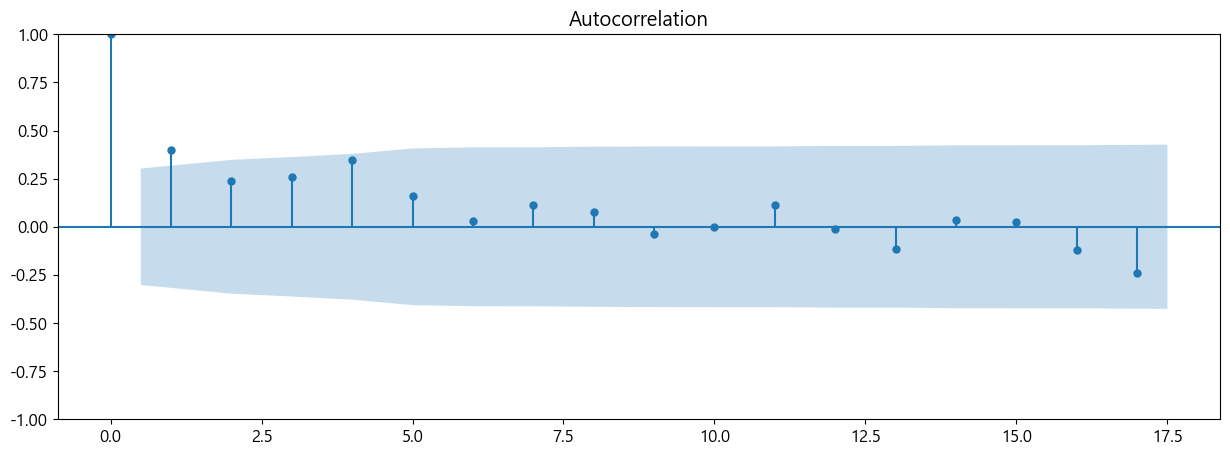

In [ ]:
plot_acf(df)
plt.show()
plt.close()

### PACF Plot

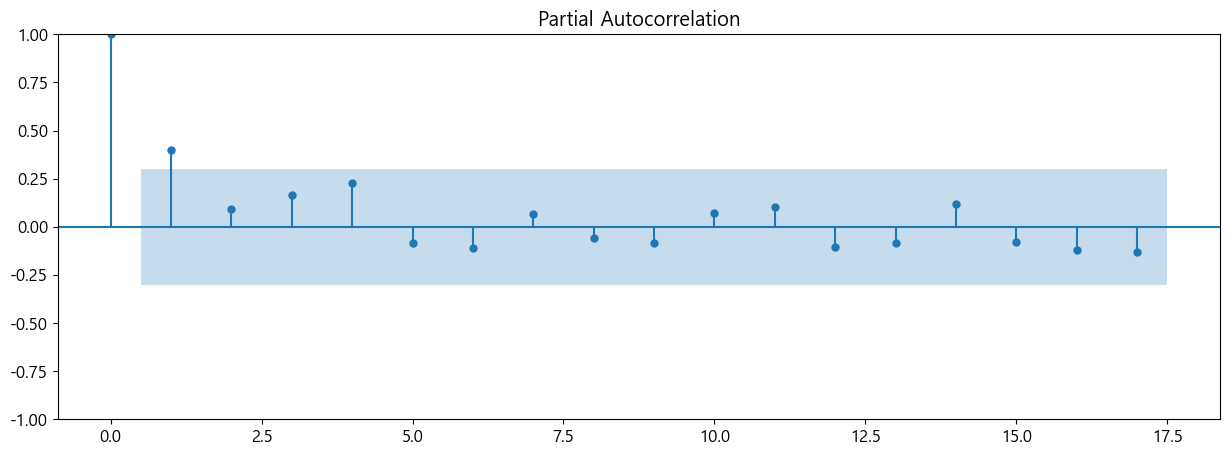

In [ ]:
plot_pacf(df)
plt.show()
plt.close()

#### 결과 판정

| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 급격 | 상대적으로 완만 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |

이 결과를 고려하여 완만함을 보이는 PACF 플롯을 채택 

$MA(1)$ 모델로 결정

### 원본 데이터에 대한 ADF 테스트

ACF, PACF Plot으로 적용할 모델을 결정한다면 차분을 몇 번 수행하는 것이 좋을지 결정해야 한다.

| 모델 | 의미 |
|---|---|
| $AR(n)$ | $ARIMA(p,d,q)$ 중에서 $p=n, q=0$이라는 의미 |
| $MA(n)$ | $ARIMA(p,d,q)$ 중에서 $p=0, q=n$이라는 의미 |

ADF 테스트의 결과로 차분의 횟수가 결정되면 이 값이 $d$를 의미함.

#### ADF 테스트의 가설

| 가설 | 내용 |
|---|---|
| 귀무가설 | 데이터가 정상성과 다르다 (=비정상성임을 의미) |
| 대립가설 | 데이터가 정상성이다. |

In [ ]:
ar = adfuller(df)

print('ADF Statistic: %f' % ar[0])
print('p-value: %f' % ar[1])
print('num of lags: %f' % ar[2])
print('num of observations: %f' % ar[3])
print('Critical Values:')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.090230
p-value: 0.001005
num of lags: 0.000000
num of observations: 41.000000
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


p-value가 0.05보다 작으므로 귀무가설을 기각하도 대립가설 채택. 즉 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

대립가설이 채택될 때 까지 이 과정을 반복함

반복횟수가 $d$ 값이 됨 

> 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

## #03. 차분 수행

In [ ]:
diff1 = df.diff().dropna()
diff1.head()

,age
1,-17.0
2,24.0
3,-17.0
4,6.0
5,-14.0


### 차분 결과로 ADF 테스트 다시 수행

In [ ]:
ar = adfuller(diff1)

print('ADF Statistic: %f' % ar[0])
print('p-value: %f' % ar[1])
print('num of lags: %f' % ar[2])
print('num of observations: %f' % ar[3])
print('Critical Values:')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.300508
p-value: 0.000000
num of lags: 2.000000
num of observations: 38.000000
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


## #04. ARIMA 분석 수행

- transformed : Whether or not start_params is already transformed. Default is True

In [ ]:
model = ARIMA(df['age'], order=(0,1,1))
fit = model.fit(transformed=False)

#model = ARIMA(diff1['age'], order=(0,1,1))
#fit = model.fit(transformed=True)

print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    age   No. Observations:                   42
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -170.064
Date:                Thu, 03 Aug 2023   AIC                            344.127
Time:                        09:48:13   BIC                            347.554
Sample:                             0   HQIC                           345.375
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7218      0.146     -4.957      0.000      -1.007      -0.436
sigma2       230.4371     57.900      3.980      0.000     116.956     343.919
Ljung-Box (L1) (Q):                   0.12   Jarque-

### 

In [ ]:
start_index = 0
end_index = len(df['age'])+10
forecast = fit.predict(start=start_index, end=end_index)
forecast

# 0부터 시작하는걸 기억해야 함

0      0.000000
1     59.990024
2     51.063271
3     57.238832
4     54.842807
5     55.195416
6     51.345423
7     50.961688
8     54.918408
9     58.582727
10    54.231868
11    57.233391
12    50.762957
13    49.715462
14    45.341788
15    46.359756
16    44.868396
17    36.001266
18    35.722676
19    40.529828
20    44.834146
21    36.811544
22    38.533372
23    47.010168
24    50.346123
25    49.693357
26    52.282763
27    61.663976
28    59.809845
29    62.088608
30    59.003403
31    51.768425
32    50.998161
33    55.450384
34    61.446176
35    66.886674
36    66.918205
37    68.053891
38    71.655912
39    70.638720
40    70.461008
41    72.280365
42    67.750647
43    67.750647
44    67.750647
45    67.750647
46    67.750647
47    67.750647
48    67.750647
49    67.750647
50    67.750647
51    67.750647
52    67.750647
Name: predicted_mean, dtype: float64

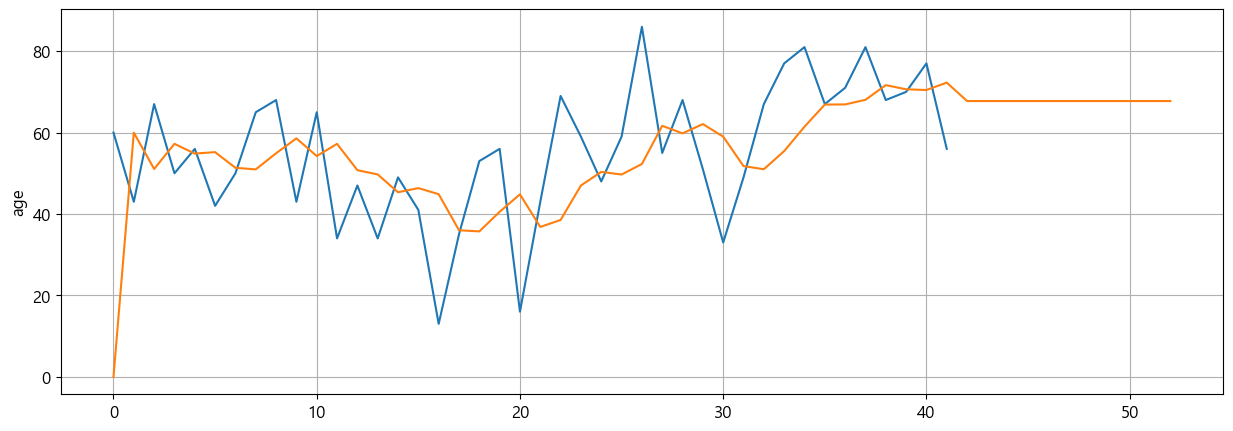

In [ ]:
plt.figure()
sb.lineplot(x=df.index, y=df['age'])
sb.lineplot(x=forecast.index, y=forecast)
plt.grid()
plt.show()
plt.close()

### 05. Auto ARIMA

In [ ]:
model = auto_arima(x=df.index,
                   y=df['age'], 
                   d=1,                     # 차분 횟수 (default=1)
                   start_p=1,               # default=2
                   max_p=3,                 # default=5 
                   start_q=1,               # default=2
                   max_q=3,                 # default=5
                   seasonal=True,           # 계절성을 고려 여부 (default=True)
                   trace=True,              # 자동으로 ARIMA 모델을 찾는 과정을 출력
                   error_action='ignore',   # 에러가 발생하면 무시
                   suppress_warnings=True   # 경고를 무시
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=347.271, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=357.938, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=354.034, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=345.813, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=355.940, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=347.178, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=349.158, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=344.127, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=345.736, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=345.628, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=352.041, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=347.574, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.490 seconds


In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -170.064
Date:                Thu, 03 Aug 2023   AIC                            344.127
Time:                        10:18:05   BIC                            347.554
Sample:                             0   HQIC                           345.375
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7218      0.146     -4.957      0.000      -1.007      -0.436
sigma2       230.4371     57.900      3.980      0.000     116.956     343.919
Ljung-Box (L1) (Q):                   0.12   Jarque-

In [ ]:
start_index = 0
end_index = len(df['age'])+10
forecast = model.predict(start=start_index, end=end_index)
forecast

42    67.750647
43    67.750647
44    67.750647
45    67.750647
46    67.750647
47    67.750647
48    67.750647
49    67.750647
50    67.750647
51    67.750647
dtype: float64

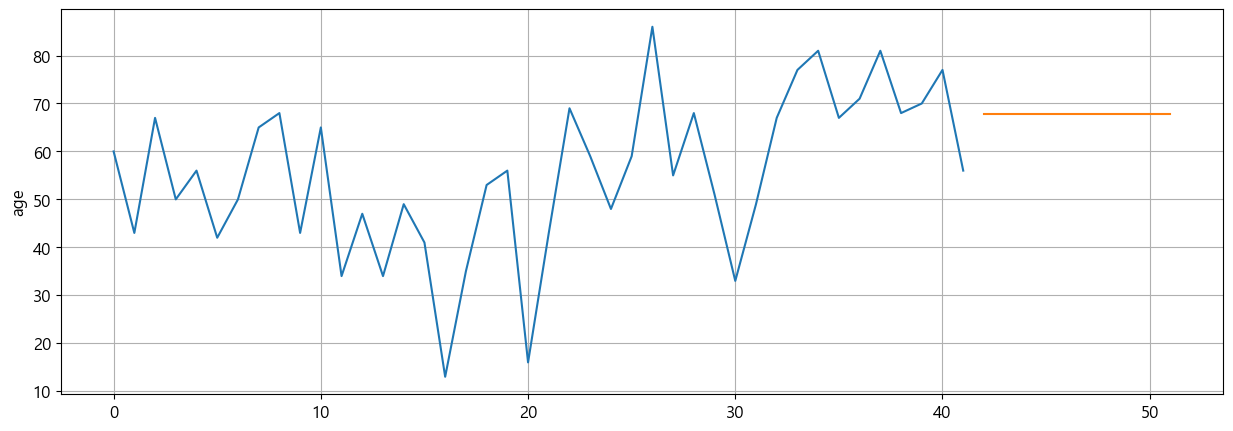

In [ ]:
plt.figure()
sb.lineplot(x=df.index, y=df['age'])
sb.lineplot(x=forecast.index, y=forecast)
plt.grid()
plt.show()
plt.close()